# Distribution of cell size (volume, surface, and volume-to-surface ratio)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend import Legend

In [2]:
from scipy.stats import norm, kstest, probplot, mode, kurtosis, skew

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [4]:
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

In [5]:
#%matplotlib widget
# %matplotlib notebook

In [6]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 11,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [7]:
# Function for kernel density estimation
def kde(x, x_grid, bandwidth = 0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # Returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)
#     return log_pdf

In [8]:
# Function to adjust hyperparameter by cross-validation
def hyperp(x, mn, mx, cv):
    bandwidths = 10 ** np.linspace(mn, mx, 50)
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv = cv)
    grid.fit(x[:, np.newaxis])
    return grid.best_params_

In [9]:
def hypo_testing(test_statistic, n):
    '''
    Functions that performs hypothesis testing and calculate the critical value
    of the K-S test
    Inputs:
        test_statistic: float containing the value of the test statistic
        n: integer containg the sample size. 
    '''
    if n > 50:
        critical_value = 1.63 / np.sqrt(n)
    
    if test_statistic > critical_value:
        return 'Reject Ho'
    else:
        return 'Not enough evidence to reject Ho'

In [10]:
def pdf_normal(mean, std, x):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(- (x - mean)**2 / (2 * std**2))

Load data

In [11]:
df = pd.read_table('../phylogeny/place/fine_all.tsv', index_col = 0)
df.head()

,length,width,volume,surface,shape,species,genus,family,order,class,...,rank,node,genome,gc,proteins,coding,rrnas,MILC,ENCprime,hash
taxid,,,,,,,,,,,,,,,,,,,,,
taxid11,2.371708,1.060660,1.783187,7.902917,rod-shaped,Cellulomonas gilvus,Cellulomonas,Cellulomonadaceae,Micrococcales,Actinomycetia,...,species,G000218545,3526441.0,73.81,3206.0,91.772782,2.0,-0.262005,0.100836,1.88
taxid14,10.000000,0.489898,1.854174,15.390598,rod-shaped,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,Dictyoglomia,...,species,G000020965,1959987.0,33.74,1890.0,93.777255,2.0,-0.064429,0.030205,0.58
taxid23,1.500000,0.700000,0.487470,3.298672,rod-shaped,Shewanella colwelliana,Shewanella,Shewanellaceae,Alteromonadales,Gammaproteobacteria,...,species,G000518705,4575622.0,45.39,4094.0,87.383136,0.0,-0.653363,0.248987,1.25
taxid104,1.039230,0.346410,0.087062,1.130973,ring-shaped,Cyclobacterium marinum,Cyclobacterium,Cyclobacteriaceae,Cytophagales,Cytophagia,...,species,G000222485,6221273.0,38.15,5114.0,87.121317,3.0,-0.200638,0.102722,1.33
taxid114,2.049390,2.049390,4.506844,13.194689,spherical,Gemmata obscuriglobus,Gemmata,Gemmataceae,Gemmatales,Planctomycetia,...,species,G000171775,9161841.0,67.18,8067.0,84.083188,3.0,-0.154188,0.056476,1.00


In [12]:
# Reformat shape column
def refShape(s):
    if 'shaped' in str(s):
        return s.split('-')[0]
    # Cyanobacteira - modeled as sphere
    elif str(s) == 'sphere/spheroid':
        return 'sphere'
    elif str(s) in ['rods']:
        return 'rod'
    elif '/' in str(s):
        return '-'.join(s.split('/'))
    else:
        return s

In [13]:
def refShape1(s):
    if str(s) in ['ovoid', 'oval', 'ellipsoidal']:
        return 'ovoid'
    elif str(s) == 'pear':
        return 'sphere'
    elif str(s) in ['sphere', 'spherical']:
        return 'sphere'
    else:
        return s

In [14]:
def assignColor(p):
    if p == 'Proteobacteria':
        return '#c05761'
    elif p == 'Bacteroidetes':
        return '#ff924c'
    elif p == 'Firmicutes':
        return '#ffca3a'
    elif p == 'Actinobacteria':
        return '#8ac926'
    elif p == 'Tenericutes':
        return '#52a675'
    elif p == 'Euryarchaeota':
        return '#1982c4'
    elif p == 'Spirochaetes':
        return '#4267ac'
    elif p == 'Cyanobacteria':
        return '#6a4c93'
    else:
        return '#495057'

In [15]:
df['shape'] = df['shape'].map(refShape)
df['shape'] = df['shape'].map(refShape1)

In [16]:
df['color'] = df['phylum'].map(assignColor)

Frequency distribution of cell size

In [17]:
df['svratio'] = df['volume'] / df['surface']

In [18]:
dimensions = ['volume', 'surface', 'svratio']

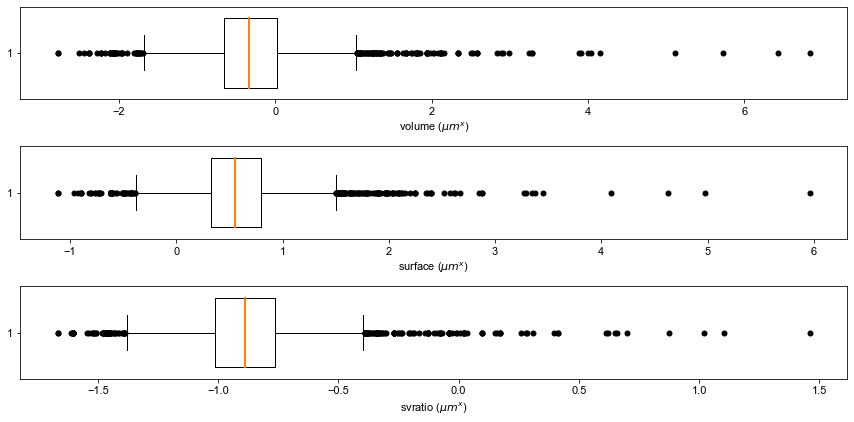

In [19]:
fig, ax = plt.subplots(3, 1, figsize = (12, 6))
for i, dim in enumerate(dimensions):
    data = np.log10(df[dim])
        
    ax[i].boxplot(data, widths = 0.75, vert = False, sym = 'ko')
    ax[i].set_xlabel(f'{dim} ($\\mu m^x$)')
    
plt.show()

('Reject Ho', KstestResult(statistic=0.06350617701765093, pvalue=2.630678177941848e-19), (-0.3186729569186747, 0.6563171751093615))

('Reject Ho', KstestResult(statistic=0.06171139769741052, pvalue=2.9688188510961023e-18), (0.5692915533672656, 0.4512385529769969))

('Reject Ho', KstestResult(statistic=0.062361473172684034, pvalue=1.2440966946415658e-18), (-0.8879645102859404, 0.2342495792347394))



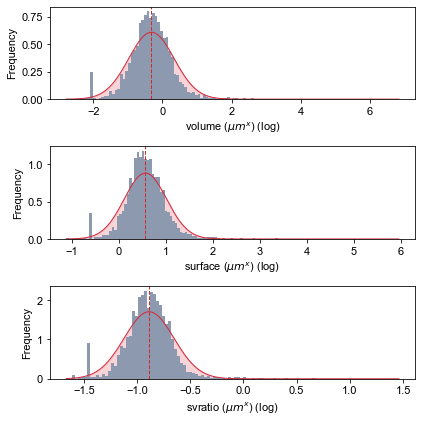

In [20]:
log = False

fig, ax = plt.subplots(3, 1, figsize = (6, 6), sharey = False)

for i, dim in enumerate(dimensions):
    
    data = np.log10(df[dim])
    label = f'{dim} ($\\mu m^x$) (log)'
        
    n = data.shape[0]
    # Fit a normal distribution to data
    parameters = norm.fit(data)
    # Perform Kolmogorov-Smirnov test (goodness of fit)
    gft = kstest(data, 'norm', parameters)
    # Hypothesis testing (Ho: normal)
    print(f'{hypo_testing(gft[0], n), gft, parameters}\n')
    
    # Plot
    count, bins, ignore = ax[i].hist(data, bins = 'auto', density = True, color = '#8d99ae', edgecolor = None)
    ax[i].plot(bins, pdf_normal(parameters[0], parameters[1], bins), color = '#d62839', linewidth = 1,
              linestyle = 'solid')
    ax[i].fill_between(bins, pdf_normal(parameters[0], parameters[1], bins), 
                       color = '#d62839', linewidth = 1, alpha = 0.2)
    ax[i].axvline(x = parameters[0], color = '#d62828', linestyle = 'dashed', linewidth = 1)
    
    ax[i].set_ylabel(f'Frequency')
    ax[i].set_xlabel(label)
    if log:
        ax[i].set_yscale('log')
        ax[i].set_xscale('log')

plt.show()

## Statistical test

Testing normality

In [21]:
res = []
for dim in ['volume', 'surface', 'svratio']:
    data = np.log10(df[dim])  
    # Fit a normal distribution to data
    parameters = norm.fit(data)
    # Perform Kolmogorov-Smirnov test (goodness of fit)
    gft = kstest(data, 'norm', parameters)
    res.append([dim, parameters[0], parameters[1], 10 ** parameters[0], 10 ** parameters[1], gft[0], gft[1]])

In [22]:
dfr_norm = pd.DataFrame(res, 
        columns = ['metric', 'mean', 'std', 'mean_lin', 'std_lin', 'KS_statistic', 'pvalue']).set_index('metric')
dfr_norm.shape

(3, 6)

## Correct p-values due to multiple testing using Benjamini/Hochberg

In [23]:
pvals_corrected = multipletests(dfr_norm['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]

In [24]:
dfr_norm['pvalue_corrected'] = pvals_corrected

In [25]:
dfr_norm

,mean,std,mean_lin,std_lin,KS_statistic,pvalue,pvalue_corrected
metric,,,,,,,
volume,-0.318673,0.656317,0.480095,4.532285,0.063506,2.630678e-19,7.892035e-19
surface,0.569292,0.451239,3.709297,2.826432,0.061711,2.968819e-18,2.968819e-18
svratio,-0.887965,0.234250,0.129430,1.714943,0.062361,1.244097e-18,1.866145e-18


In [26]:
dfr_norm.to_csv('cellsize_distribution_normal.csv', sep = '\t')

## Only volume-to-surface ratio

In [27]:
data = np.log10(df['svratio'])
n = data.shape[0]
parameters = norm.fit(data)

In [28]:
mu = np.mean(data)
std = np.std(data)
med = np.median(data)
mod = mode(data)[0][0] 

In [30]:
print(f'The mean is {mu}, {10 ** mu}')
print(f'The sd is {std}, {10 ** std}')
print(f'The median is {med}, {10 ** med}')
print(f'The mode is {mod}, {10 ** mod}')

The mean is -0.8879645102859404, 0.1294301604979106
The sd is 0.2342495792347394, 1.7149425631561783
The median is -0.8872528464376179, 0.12964242724456923
The mode is -1.4525220893459427, 0.035275884393106166


The value of the mode does not make sense. The mode takes the value of the peak of the distribution!

Number of species within 2 sd deviations

In [31]:
data.shape

(5380,)

In [32]:
data[(data > mu - 2 * std) & (data < mu + 2 * std)].shape

(5069,)

In [33]:
5069 / 5380

0.9421933085501859

Number of species outside 2 sd deviations

In [34]:
data[data <= mu - 2 * std].shape

(195,)

In [35]:
data[data >= mu + 2 * std].shape

(116,)

In [36]:
data[data <= mu - 2 * std].shape[0] + data[data >= mu + 2 * std].shape[0]

311

In [37]:
311 / 5380

0.057806691449814124

Number of species outsie 3 sd deviations

In [38]:
data[data <= mu - 3 * std].shape

(19,)

In [39]:
data[data >= mu + 3 * std].shape

(56,)

**Assesing kurtosis**

In [40]:
kurtosis(data)

7.949412311768244

**Assesing skewness**

In [41]:
skew(data)

0.9509431291358605

In [42]:
count, bins = np.histogram(data, bins = 'auto', density = True)

In [43]:
count_normal = pdf_normal(parameters[0], parameters[1], bins[1:])

QQ plot

In [44]:
qq = probplot(data, sparams = (parameters[0], parameters[1]), dist = 'norm')

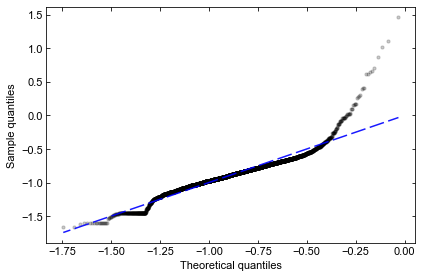

In [45]:
plt.figure()
plt.scatter(qq[0][0], qq[0][1], alpha = 0.2, color = 'black', s = 10)
plt.plot(qq[0][0], qq[0][0], color = 'blue', alpha = 0.9, linestyle = (5, (10, 3)))
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.savefig('../figures_all/qqplot_svratio_new.svg') 
plt.show()

By default the density is calculated as. `density = counts / (n_samples * bin_width)`. However the returned values are not normalized to be considered actual probability values. [Normalize](https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1) `density` such that it represents the probablity density (i.e. area under the curve of the PDF) at the bin (i.e. at the range of values given by the bin)

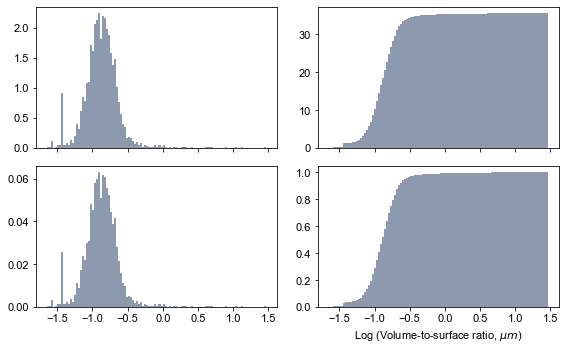

In [46]:
density, bins = np.histogram(data, bins = 'auto', density = True)
widths = bins[:-1] - bins[1:]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,5))

ax1.bar(bins[1:], density, width = widths, color = '#8d99ae')
ax2.bar(bins[1:], density.cumsum(), width = widths, color = '#8d99ae')

ax3.bar(bins[1:], density / density.sum(), width = widths, color = '#8d99ae')
ax4.bar(bins[1:], (density / density.sum()).cumsum(), width = widths, color = '#8d99ae')

plt.xlabel('Log (Volume-to-surface ratio, $\\mu m$)')
# plt.ylabel('Number of species')
plt.show()

Using number of species instead of density for easier interpretability

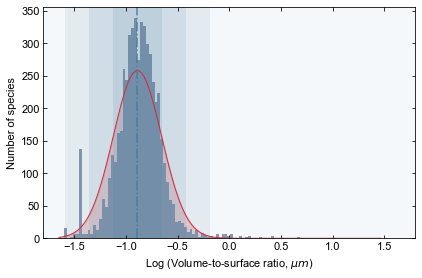

In [47]:
counts, bins = np.histogram(data, bins = 'auto')
widths = bins[:-1] - bins[1:]

plt.figure(figsize = (6, 4))
# plt.hist(data, bins = 'auto', color = '#8d99ae', edgecolor = None)
plt.bar(bins[1:], counts, width = widths, color = '#8d99ae')

# Add fitted normal distribution, normalized such that the area under the curve represents the 
# number of species per cell size
y_fitted = norm.pdf(bins[1:], parameters[0], parameters[1]) * len(data) * np.diff(bins[1:])[0]
plt.plot(bins[1:], y_fitted, color = '#d62839', linewidth = 1,
              linestyle = 'solid')
plt.fill_between(bins[1:], y_fitted, 
                 color = '#d62839', linewidth = 1, alpha = 0.2)

# Mean and std
plt.axvline(x = mu, color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)
for i in range(0, 4):
    low_r = mu + std * i
    up_r = mu + std * (i + 1)
    low_l = mu - std * i
    up_l = mu - std * (i + 1)
    if i == 3:
        up_r = 1.8
        up_l = -1.8
    plt.axvspan(low_r, up_r, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)
    plt.axvspan(low_l, up_l, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(-1.8, 1.8)
plt.xlabel('Log (Volume-to-surface ratio, $\\mu m$)')
plt.ylabel('Number of species')

plt.savefig('../figures_all/attractor_hist.svg') 
plt.show()

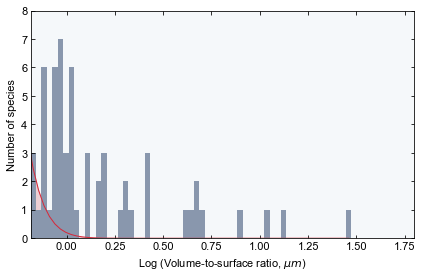

In [48]:
counts, bins = np.histogram(data, bins = 'auto')
widths = bins[:-1] - bins[1:]

plt.figure(figsize = (6, 4))
# plt.hist(data, bins = 'auto', color = '#8d99ae', edgecolor = None)
plt.bar(bins[1:], counts, width = widths, color = '#8d99ae')

# Add fitted normal distribution, normalized such that the area under the curve represents the 
# number of species per cell size
y_fitted = norm.pdf(bins[1:], parameters[0], parameters[1]) * len(data) * np.diff(bins[1:])[0]
plt.plot(bins[1:], y_fitted, color = '#d62839', linewidth = 1,
              linestyle = 'solid')
plt.fill_between(bins[1:], y_fitted, 
                 color = '#d62839', linewidth = 1, alpha = 0.2)

# Mean and std
plt.axvline(x = mu, color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)
for i in range(0, 4):
    low_r = mu + std * i
    up_r = mu + std * (i + 1)
    low_l = mu - std * i
    up_l = mu - std * (i + 1)
    if i == 3:
        up_r = 1.8
        up_l = -1.8
    plt.axvspan(low_r, up_r, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)
    plt.axvspan(low_l, up_l, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)


plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(mu + std * 3, 1.8)
plt.ylim(0, 8)
plt.xlabel('Log (Volume-to-surface ratio, $\\mu m$)')
plt.ylabel('Number of species')

plt.savefig('../figures_all/attractor_hist_inset.svg')  
plt.show()

Stability landscape

In [52]:
x_grid = np.linspace(data.min(), data.max(), data.shape[0])
bw = hyperp(data, -1, 1, 5)
pdf = kde(data, x_grid, bandwidth = bw['bandwidth'])

<ipython-input-8-a91e6193a18d>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(x[:, np.newaxis])
<ipython-input-7-d0027057d745>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde_skl.fit(x[:, np.newaxis])


In [53]:
pdf_n = norm.pdf(x_grid, parameters[0], parameters[1])

In [54]:
pdf.shape

(5380,)

In [55]:
pdf_n.shape

(5380,)

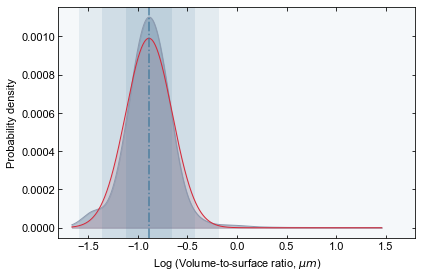

In [56]:
plt.figure(figsize = (6, 4))
    
# Values of PDF are normalized, such that they are tru probabilities
# and their sum gives one (i.e. a true probability!)
plt.plot(x_grid, pdf / pdf.sum(), color = '#8d99ae', lw = 1)
plt.fill_between(x_grid, pdf / pdf.sum(), color = '#8d99ae', alpha = 0.5)
plt.plot(x_grid, pdf_n / pdf_n.sum(), color = '#d62839', linewidth = 1,
               linestyle = 'solid')
plt.fill_between(x_grid, pdf_n / pdf_n.sum(), 
                 color = '#d62839', linewidth = 1, alpha = 0.1)

# plt.plot(data, np.full_like(data, -0.04), color = 'black', marker = '|',
#                      alpha = 0.2)
    
plt.xlabel('Log (Volume-to-surface ratio, $\\mu m$)')
plt.ylabel('Probability density')

# Mean and std
plt.axvline(x = mu, color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)
for i in range(0, 4):
    low_r = mu + std * i
    up_r = mu + std * (i + 1)
    low_l = mu - std * i
    up_l = mu - std * (i + 1)
    if i == 3:
        up_r = 1.8
        up_l = -1.8
    plt.axvspan(low_r, up_r, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)
    plt.axvspan(low_l, up_l, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(-1.8, 1.8)
# plt.savefig('figures_all/attractor_kde.svg') 
plt.show()

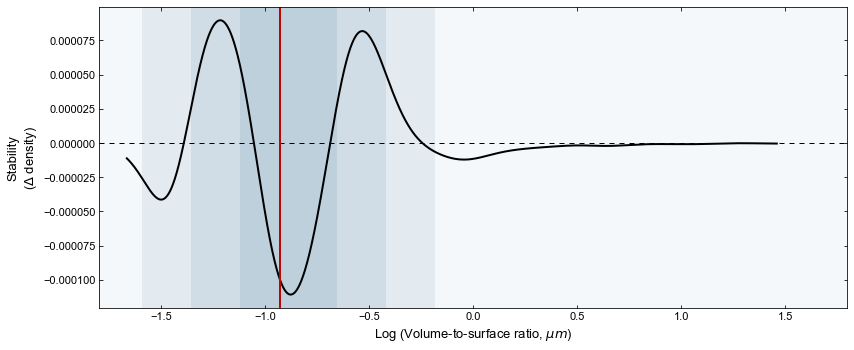

In [57]:
plt.figure(figsize = (12, 5))
plt.plot(x_grid, ((pdf_n / pdf_n.sum()) - (pdf / pdf.sum())), color = 'k',
        linewidth = 2)

# If both distributions were the same 
plt.axhline(y = 0, linestyle = (0, (5, 5)), linewidth = 1, color = 'k')
# Mean and std
plt.axvline(x = -0.93, color = '#bf0603', linestyle = 'solid', alpha = 1.0, linewidth = 2)
for i in range(0, 4):
    low_r = mu + std * i
    up_r = mu + std * (i + 1)
    low_l = mu - std * i
    up_l = mu - std * (i + 1)
    if i == 3:
        up_r = 1.8
        up_l = -1.8
    plt.axvspan(low_r, up_r, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)
    plt.axvspan(low_l, up_l, alpha = 0.35 - i * 0.1, color = '#457b9d', lw = 0)

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(-1.8, 1.8)

plt.xlabel('Log (Volume-to-surface ratio, $\\mu m$)', fontsize = 13)
plt.ylabel(f'Stability\n($\\Delta$ density)', fontsize = 13)

plt.savefig('../figures_all/attractor_final.svg')   
plt.show()

## Distributions for other metrics of cell size

In [58]:
df['survol'] = df['surface'] / df['volume']
metrics = ['length', 'width', 'volume', 'surface', 'survol', 'svratio']
xlabels = ['Log (Length, $\\mu m$)', 'Log (Width, $\\mu m$)',
          'Log (Volume, $\\mu m^3$)', 'Log (Surface area, $\\mu m^2$)',
          'Log (Surface-to-volume ratio, $1 / \\mu m$)',
          'Log (Volume-to-surface ratio, $\\mu m$)']

Metric: length
	Mean: 0.29, 1.97
	Std: 0.31, 2.06
	Median: 0.28, 1.90
	Normality: 0.08, p-value: 1.692363889609173e-27. p-value_cor: 1.692363889609173e-27
	Kurtosis: 6.13
	Skewness: 1.09
Metric: width
	Mean: -0.22, 0.60
	Std: 0.25, 1.80
	Median: -0.22, 0.60
	Normality: 0.08, p-value: 4.160505418148137e-31. p-value_cor: 4.160505418148137e-31
	Kurtosis: 7.17
	Skewness: 1.01
Metric: volume
	Mean: -0.32, 0.48
	Std: 0.66, 4.53
	Median: -0.33, 0.47
	Normality: 0.06, p-value: 2.630678177941848e-19. p-value_cor: 2.630678177941848e-19
	Kurtosis: 10.38
	Skewness: 1.15
Metric: surface
	Mean: 0.57, 3.71
	Std: 0.45, 2.83
	Median: 0.55, 3.55
	Normality: 0.06, p-value: 2.9688188510961023e-18. p-value_cor: 2.9688188510961023e-18
	Kurtosis: 10.03
	Skewness: 1.09
Metric: survol
	Mean: 0.89, 7.73
	Std: 0.23, 1.71
	Median: 0.89, 7.71
	Normality: 0.06, p-value: 1.2440966946415194e-18. p-value_cor: 1.2440966946415194e-18
	Kurtosis: 7.95
	Skewness: -0.95
Metric: svratio
	Mean: -0.89, 0.13
	Std: 0.23, 1.71
	M

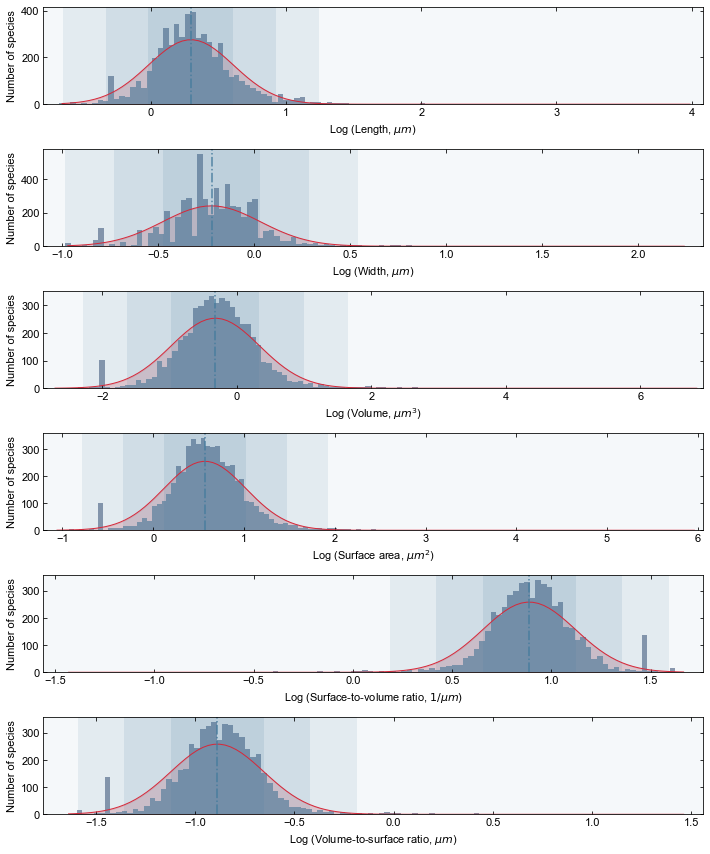

In [59]:
fig, ax = plt.subplots(len(metrics), 1, figsize = (10, 12), sharey = False, sharex = False)
for i, metric in enumerate(metrics):
    data = np.log10(df[metric])
    n = data.shape[0]
    parameters = norm.fit(data)
    # Basic statistics
    mu, std, med, kurt, skw = np.mean(data), np.std(data), np.median(data), kurtosis(data), skew(data)
    # Perform Kolmogorov-Smirnov test (goodness of fit)
    gft = kstest(data, 'norm', parameters)
    # Correct p-value due to multiple testing
    p_val_cor = multipletests(gft[1], alpha = 0.05, method = 'fdr_bh')[1]
    # Plot
    counts, bins = np.histogram(data, bins = 'auto')
    widths = bins[:-1] - bins[1:]
    ax[i].bar(bins[1:], counts, width = widths, color = '#8d99ae')
    # Add fitted normal distributio
    y_fitted = norm.pdf(bins[1:], parameters[0], parameters[1]) * len(data) * np.diff(bins[1:])[0]
    ax[i].plot(bins[1:], y_fitted, color = '#d62839', linewidth = 1,
                  linestyle = 'solid')
    ax[i].fill_between(bins[1:], y_fitted, 
                     color = '#d62839', linewidth = 1, alpha = 0.2)
    # Mean and std
    ax[i].axvline(x = mu, color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)
    for i_ in range(0, 4):
        low_r = mu + std * i_
        up_r = mu + std * (i_ + 1)
        low_l = mu - std * i_
        up_l = mu - std * (i_ + 1)
        if i_ == 3:
            up_r = np.max(data) + 0.5
            up_l = np.min(data) - 0.5
        ax[i].axvspan(low_r, up_r, alpha = 0.35 - i_ * 0.1, color = '#457b9d', lw = 0)
        ax[i].axvspan(low_l, up_l, alpha = 0.35 - i_ * 0.1, color = '#457b9d', lw = 0)
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Number of species')
    ax[i].set_xlim(np.min(data) - 0.1, np.max(data) + 0.1)
    print(f'Metric: {metric}')
    print(f'\tMean: {mu:.2f}, {(10 ** mu):.2f}')
    print(f'\tStd: {std:.2f}, {(10 ** std):.2f}')
    print(f'\tMedian: {med:.2f}, {(10 ** med):.2f}')
    print(f'\tNormality: {gft[0]:.2f}, p-value: {gft[1]}. p-value_cor: {p_val_cor[0]}')
    print(f'\tKurtosis: {kurt:.2f}')
    print(f'\tSkewness: {skw:.2f}')

plt.savefig('../figures_all/all_distributions.svg')
plt.show()

### Comparison between V/S, length, and width

In [60]:
for metric in ['svratio', 'length', 'width']:
    df[f'log_{metric}'] = np.log10(df[metric])

In [61]:
data = df['log_svratio']
annot = np.linspace(data.min(), data.max(), 15)
for a in annot:
    closest = df.iloc[(df['log_svratio'] - a).abs().argsort()[:1]]
    print(f'{a:.2f}, log_svratio: {closest["log_svratio"][0]:.2f}, length: {closest["log_length"][0]:.2f}, width: {closest["log_width"][0]:.2f}')

-1.67, log_svratio: -1.67, length: -0.61, width: -1.00
-1.44, log_svratio: -1.44, length: 0.18, width: -0.82
-1.22, log_svratio: -1.22, length: 0.37, width: -0.60
-1.00, log_svratio: -1.00, length: -0.05, width: -0.31
-0.77, log_svratio: -0.77, length: 0.16, width: -0.08
-0.55, log_svratio: -0.55, length: 0.38, width: 0.15
-0.33, log_svratio: -0.33, length: 0.45, width: 0.45
-0.10, log_svratio: -0.10, length: 0.68, width: 0.68
0.12, log_svratio: 0.10, length: 0.87, width: 0.87
0.34, log_svratio: 0.31, length: 1.09, width: 1.09
0.57, log_svratio: 0.61, length: 1.39, width: 1.39
0.79, log_svratio: 0.87, length: 3.99, width: 1.48
1.01, log_svratio: 1.02, length: 1.80, width: 1.80
1.24, log_svratio: 1.10, length: 2.39, width: 1.74
1.46, log_svratio: 1.46, length: 2.24, width: 2.24


Plots

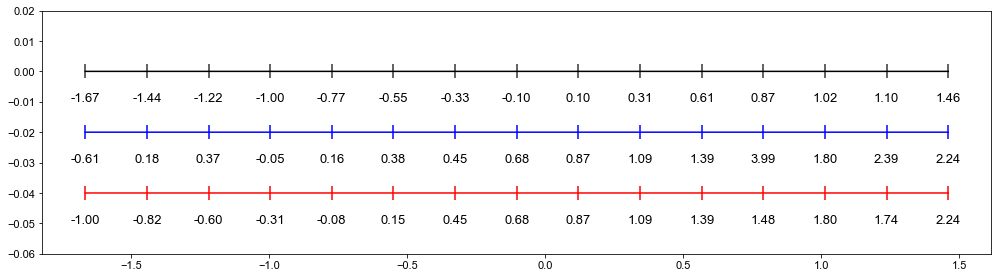

In [62]:
plt.figure(figsize = (14, 4))
data = np.sort(df['log_svratio'])
annot = np.linspace(data.min(), data.max(), 15)

plt.plot(data, np.full_like(data, 0), alpha = 1.0, color = 'k')
plt.scatter(annot, np.full_like(annot, 0), marker = '|', color = 'k', s = 200, alpha = 0.8)

plt.plot(data, np.full_like(data, -0.02), alpha = 1.0, color = 'b')
plt.scatter(annot, np.full_like(annot, -0.02), marker = '|', color = 'b', s = 200)

plt.plot(data, np.full_like(data, -0.04), alpha = 1.0, color = 'r')
plt.scatter(annot, np.full_like(annot, -0.04), marker = '|', color = 'r', s = 200)

for a in annot:
    closest = df.iloc[(df['log_svratio'] - a).abs().argsort()[:1]]
    plt.annotate(f'{closest["log_svratio"][0]:.2f}', xy = (a, -0.01), ha = 'center', fontsize = 13)
    plt.annotate(f'{closest["log_length"][0]:.2f}', xy = (a, -0.02 - 0.01), 
                 ha = 'center', fontsize = 13)
    plt.annotate(f'{closest["log_width"][0]:.2f}', xy = (a, -0.04 - 0.01), 
                 ha = 'center', fontsize = 13)
    
# # Common bacteria --The mapping between length and width is clearly non-linear
# datum = dfs['log_svratio'].values
# plt.scatter(datum, np.full_like(datum, 0.02), color='k')
    

plt.ylim(-0.06, 0.02)

plt.savefig('../figures_all/rule_all.svg')
plt.show()

In [65]:
sh_keys = [['coccus', 'sphere', 'ovoid'], ['rod'], ['filament'], ['helical', 'spiral', 'vibrio']]

Perfect spheres

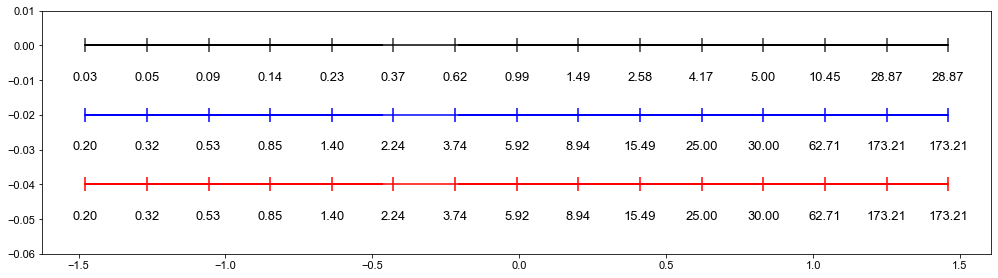

In [66]:
plt.figure(figsize = (14, 4))
data = df[df['length'] == df['width']]
annot = np.linspace(data['log_svratio'].min(), data['log_svratio'].max(), 15)

plt.plot(data['log_svratio'], np.full_like(data['log_svratio'], 0), alpha = 1.0, color = 'k')
plt.scatter(annot, np.full_like(annot, 0), marker = '|', color = 'k', s = 200, alpha = 0.8)

plt.plot(data['log_svratio'], np.full_like(data['log_svratio'], -0.02), alpha = 1.0, color = 'b')
plt.scatter(annot, np.full_like(annot, -0.02), marker = '|', color = 'b', s = 200)

plt.plot(data['log_svratio'], np.full_like(data['log_svratio'], -0.04), alpha = 1.0, color = 'r')
plt.scatter(annot, np.full_like(annot, -0.04), marker = '|', color = 'r', s = 200)

for a in annot:
    closest = data.iloc[(data['log_svratio'] - a).abs().argsort()[:1]]
    plt.annotate(f'{10 ** closest["log_svratio"][0]:.2f}', xy = (a, -0.01), ha = 'center', fontsize = 13)
    plt.annotate(f'{10 ** closest["log_length"][0]:.2f}', xy = (a, -0.02 - 0.01), 
                 ha = 'center', fontsize = 13)
    plt.annotate(f'{10 ** closest["log_width"][0]:.2f}', xy = (a, -0.04 - 0.01), 
                 ha = 'center', fontsize = 13)
    

plt.ylim(-0.06, 0.01)
plt.savefig('../figures_all/rule_spheres_all.svg')
plt.show()

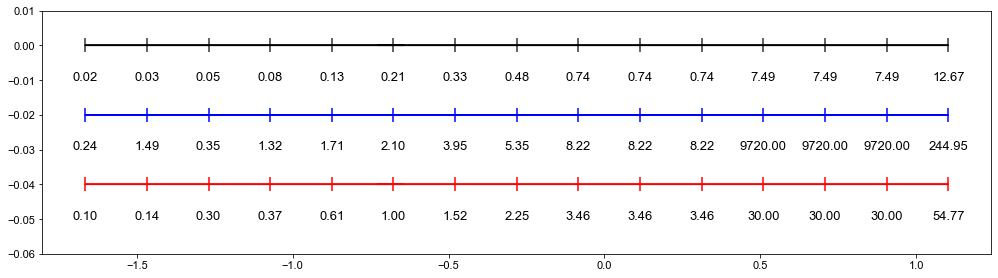

In [67]:
plt.figure(figsize = (14, 4))
data = df.query('shape == @sh_keys[1]')
annot = np.linspace(data['log_svratio'].min(), data['log_svratio'].max(), 15)

plt.plot(data['log_svratio'], np.full_like(data['log_svratio'], 0), alpha = 1.0, color = 'k')
plt.scatter(annot, np.full_like(annot, 0), marker = '|', color = 'k', s = 200, alpha = 0.8)

plt.plot(data['log_svratio'], np.full_like(data['log_svratio'], -0.02), alpha = 1.0, color = 'b')
plt.scatter(annot, np.full_like(annot, -0.02), marker = '|', color = 'b', s = 200)

plt.plot(data['log_svratio'], np.full_like(data['log_svratio'], -0.04), alpha = 1.0, color = 'r')
plt.scatter(annot, np.full_like(annot, -0.04), marker = '|', color = 'r', s = 200)

for a in annot:
    closest = data.iloc[(data['log_svratio'] - a).abs().argsort()[:1]]
    plt.annotate(f'{10 ** closest["log_svratio"][0]:.2f}', xy = (a, -0.01), ha = 'center', fontsize = 13)
    plt.annotate(f'{10 ** closest["log_length"][0]:.2f}', xy = (a, -0.02 - 0.01), 
                 ha = 'center', fontsize = 13)
    plt.annotate(f'{10 ** closest["log_width"][0]:.2f}', xy = (a, -0.04 - 0.01), 
                 ha = 'center', fontsize = 13)
    

plt.ylim(-0.06, 0.01)
plt.savefig('../figures_all/rule_rods_all.svg')
plt.show()

Test your values

In [68]:
length, width = 0.91, 0.54
vol = np.pi * ((10 ** width) / 2) ** 2 * ((4 / 3) * ((10 ** width) / 2) + ((10 ** length) - (10 ** width)))
sur = 2 * np.pi * ((10 ** width) / 2) * (2 * ((10 ** width) / 2) + ((10 ** length) - (10 ** width)))
print(np.log10(vol/sur))

-0.12867049297194488
